# increasing number of genes to show increasing classification accuracy


In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
from scprint.tasks import Embedder

from scipy.stats import spearmanr
from anndata import AnnData

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")


LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/temp/" #"../../data/temp/"  #

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [1]:
adata = sc.read(
    LOC + "glio_smart_cort_area" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/a1d40c84-c81c-406f-bef4-e25edeb651e5.h5ad",
)
# adata = sc.read(
#    LOC + "glio_smart_highdepth" + ".h5ad",
#    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
# )

In [3]:
(adata.X > 0).sum(1).mean()

7376.551793917073

In [29]:
adata.X.data[:10]

array([ 41.,  36.,   1., 639.,   1.,   5.,   9., 149.,  17., 149.],
      dtype=float32)

In [ ]:
adata.obs.cell_type.value_counts()

cell_type
glutamatergic neuron                                              21841
L2/3-6 intratelencephalic projecting glutamatergic neuron          4778
VIP GABAergic cortical interneuron                                 3533
pvalb GABAergic cortical interneuron                               2800
L6 corticothalamic-projecting glutamatergic cortical neuron        2556
lamp5 GABAergic cortical interneuron                               2434
sst GABAergic cortical interneuron                                 2358
unknown                                                            1985
oligodendrocyte                                                    1930
astrocyte                                                          1187
L6b glutamatergic cortical neuron                                  1080
near-projecting glutamatergic cortical neuron                       816
oligodendrocyte precursor cell                                      773
microglial cell                                       

In [2]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=True,
)
print(adata.X.sum(1).mean())
adata = preprocessor(adata)

1353725.5
Dropping layers:  KeysView(Layers with keys: exon, intron)
checking raw counts
removed 0 non primary cells, 49417 renamining
filtered out 0 cells, 49417 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 34323 genes in the ontology but not present in the dataset
starting QC
Seeing 10180 outliers (20.60% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 49417 × 70116
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere 

In [3]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/18hebyht-final-small.ckpt"
# w937u4o1

In [4]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


/local/scratch/tmp/ipykernel_667407/4282362098.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)
... storing 'organism_ontology_term_id' as categorical
... storing 'batches' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


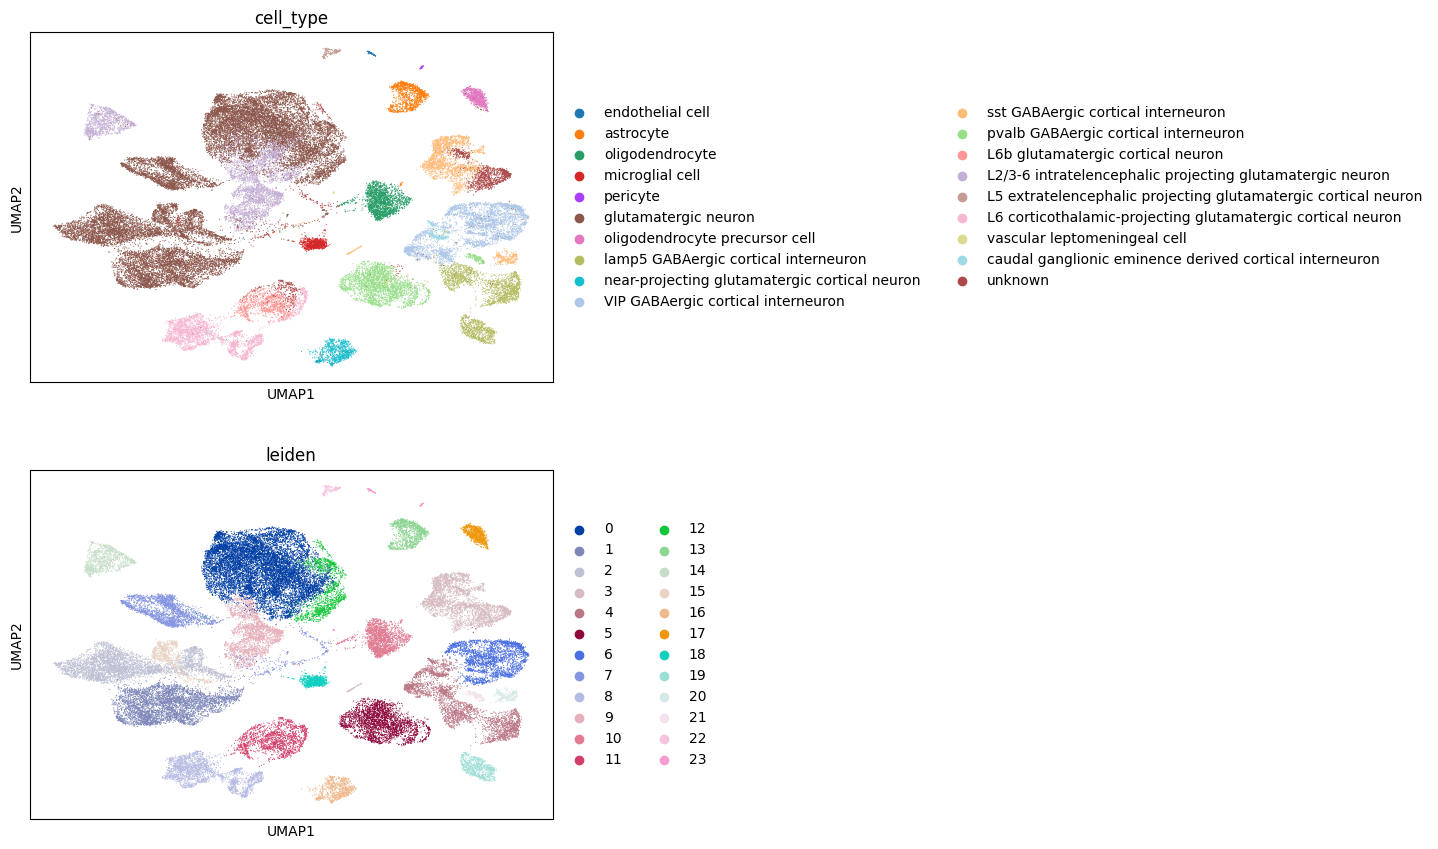

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["cell_type", "leiden"], ncols=1)

In [9]:
metrics = {}
for n in [200, 500, 1000, 2000, 4000, 8000]:
    ad = adata[(adata.X > 0).sum(1) >= n]
    # Get 5,000 random cells
    n_cells = min(5000, ad.n_obs)  # In case you have fewer than 5,000 cells
    random_indices = np.random.choice(ad.n_obs, n_cells, replace=False)
    adata_subset = ad[random_indices, :].copy()
    embed = Embedder(
        how="random expr",
        max_len=n,
        num_workers=8,
        pred_embedding=["cell_type_ontology_term_id"],
        doplot=False,
    )
    _, metrics[n] = embed(model, adata_subset.copy())

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [00:08<00:00,  9.86it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 17465
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [00:07<00:00, 11.09it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 17987
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [00:07<00:00,  9.88it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 18293
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 18526
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [00:32<00:00,  2.45it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 18783
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 79/79 [01:00<00:00,  1.31it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5000 × 18966
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [10]:
metrics

{200: {'cell_type_ontology_term_id_accuracy': 0.5383653044203502,
  'tissue_ontology_term_id_accuracy': 0.2044,
  'disease_ontology_term_id_accuracy': 0.9872,
  'assay_ontology_term_id_accuracy': 0.9888,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.468,
  'sex_ontology_term_id_accuracy': 0.4762,
  'organism_ontology_term_id_accuracy': 0.966},
 500: {'cell_type_ontology_term_id_accuracy': 0.5963226076055161,
  'tissue_ontology_term_id_accuracy': 0.2876,
  'disease_ontology_term_id_accuracy': 0.997,
  'assay_ontology_term_id_accuracy': 0.9994,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.5692,
  'sex_ontology_term_id_accuracy': 0.5782,
  'organism_ontology_term_id_accuracy': 0.9948},
 1000: {'cell_type_ontology_term_id_accuracy': 0.6194948862450428,
  'tissue_ontology_term_id_accuracy': 0.3088,
  'disease_ontology_term_id_accuracy': 0.9974,
  'assay_ontology_term_id_accuracy': 1.0,
  'self_reported_ethnicity_ontology_term_id_accuracy': 0.7154,
  'sex_ontology_term

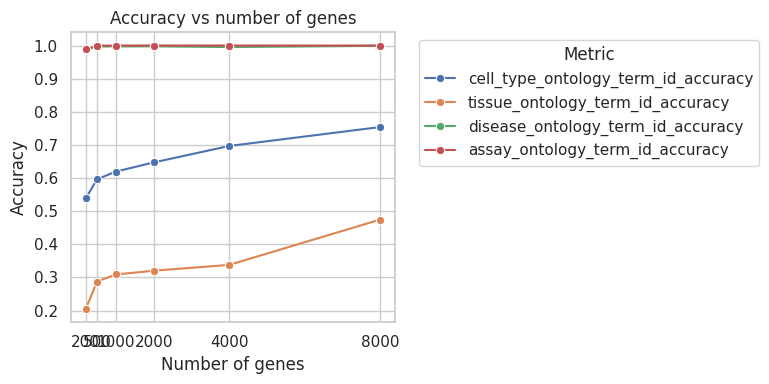

In [11]:
import pandas as pd
import seaborn as sns

metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.5383653044203502,
        "tissue_ontology_term_id_accuracy": 0.2044,
        "disease_ontology_term_id_accuracy": 0.9872,
        "assay_ontology_term_id_accuracy": 0.9888,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.468,
        "sex_ontology_term_id_accuracy": 0.4762,
        "organism_ontology_term_id_accuracy": 0.966,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.5963226076055161,
        "tissue_ontology_term_id_accuracy": 0.2876,
        "disease_ontology_term_id_accuracy": 0.997,
        "assay_ontology_term_id_accuracy": 0.9994,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.5692,
        "sex_ontology_term_id_accuracy": 0.5782,
        "organism_ontology_term_id_accuracy": 0.9948,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.6194948862450428,
        "tissue_ontology_term_id_accuracy": 0.3088,
        "disease_ontology_term_id_accuracy": 0.9974,
        "assay_ontology_term_id_accuracy": 1.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.7154,
        "sex_ontology_term_id_accuracy": 0.722,
        "organism_ontology_term_id_accuracy": 0.9994,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.6470710860954764,
        "tissue_ontology_term_id_accuracy": 0.3202,
        "disease_ontology_term_id_accuracy": 0.9976,
        "assay_ontology_term_id_accuracy": 1.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.8802,
        "sex_ontology_term_id_accuracy": 0.8878,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6966854283927455,
        "tissue_ontology_term_id_accuracy": 0.3378,
        "disease_ontology_term_id_accuracy": 0.9954,
        "assay_ontology_term_id_accuracy": 1.0,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9842,
        "sex_ontology_term_id_accuracy": 0.9824,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.75391685815751,
        "tissue_ontology_term_id_accuracy": 0.4746,
        "disease_ontology_term_id_accuracy": 0.9992,
        "assay_ontology_term_id_accuracy": 0.9998,
        "self_reported_ethnicity_ontology_term_id_accuracy": 0.9958,
        "sex_ontology_term_id_accuracy": 0.995,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

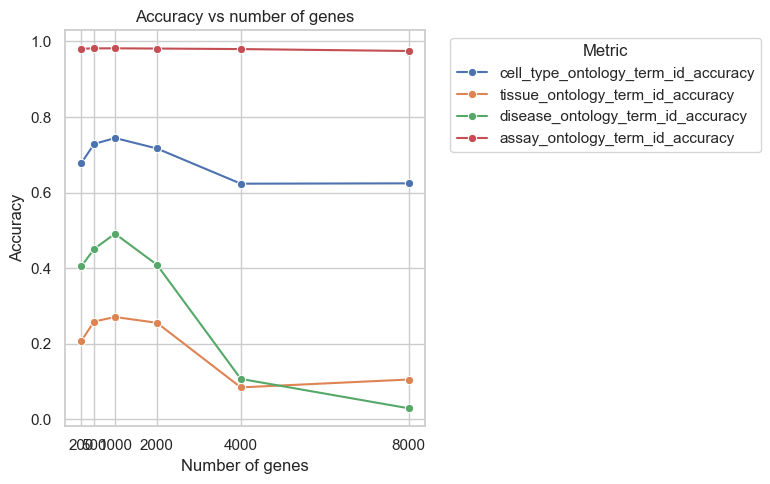

In [18]:
metrics = {
    200: {
        "cell_type_ontology_term_id_accuracy": 0.6787216148023549,
        "tissue_ontology_term_id_accuracy": 0.2082982898794505,
        "disease_ontology_term_id_accuracy": 0.4053826745164003,
        "assay_ontology_term_id_accuracy": 0.9806560134566863,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    500: {
        "cell_type_ontology_term_id_accuracy": 0.728623493131483,
        "tissue_ontology_term_id_accuracy": 0.2590412111017662,
        "disease_ontology_term_id_accuracy": 0.4510793383795907,
        "assay_ontology_term_id_accuracy": 0.9817774039809364,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    1000: {
        "cell_type_ontology_term_id_accuracy": 0.7446033081020466,
        "tissue_ontology_term_id_accuracy": 0.27109615923745445,
        "disease_ontology_term_id_accuracy": 0.49144939725259323,
        "assay_ontology_term_id_accuracy": 0.9817774039809364,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    2000: {
        "cell_type_ontology_term_id_accuracy": 0.7168488926268572,
        "tissue_ontology_term_id_accuracy": 0.255677039529016,
        "disease_ontology_term_id_accuracy": 0.40930754135127556,
        "assay_ontology_term_id_accuracy": 0.9812167087188113,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    4000: {
        "cell_type_ontology_term_id_accuracy": 0.6237734791141015,
        "tissue_ontology_term_id_accuracy": 0.08494533221194281,
        "disease_ontology_term_id_accuracy": 0.10737314269694422,
        "assay_ontology_term_id_accuracy": 0.9798149705634988,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
    8000: {
        "cell_type_ontology_term_id_accuracy": 0.6246145220072891,
        "tissue_ontology_term_id_accuracy": 0.10569105691056911,
        "disease_ontology_term_id_accuracy": 0.02971684889262686,
        "assay_ontology_term_id_accuracy": 0.9747687132043734,
        "self_reported_ethnicity_ontology_term_id_accuracy": 1.0,
        "sex_ontology_term_id_accuracy": 1.0,
        "organism_ontology_term_id_accuracy": 1.0,
    },
}

import matplotlib.pyplot as plt

# create a DataFrame from the metrics dict
df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "n_genes"})

# keep only the four metrics to plot
cols = [
    "cell_type_ontology_term_id_accuracy",
    "tissue_ontology_term_id_accuracy",
    "disease_ontology_term_id_accuracy",
    "assay_ontology_term_id_accuracy",
]
df = df[["n_genes"] + cols].sort_values("n_genes")

# melt for seaborn
df_melt = df.melt(
    id_vars="n_genes", value_vars=cols, var_name="metric", value_name="accuracy"
)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melt, x="n_genes", y="accuracy", hue="metric", marker="o")
plt.xticks(df["n_genes"])
plt.xlabel("Number of genes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of genes")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# with the novel annotation remapping


In [6]:
embed = Embedder(
    how="random expr",
    max_len=8000,
    num_workers=8,
    pred_embedding=["cell_type_ontology_term_id"],
    doplot=False,
    save_every=10_000,
    keep_all_labels_pred=True,
)
nadata, metrics = embed(model, adata.copy())

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


 20%|██        | 156/773 [01:16<05:05,  2.02it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 19041
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 40%|████      | 313/773 [03:08<03:25,  2.24it/s]  

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 19042
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 61%|██████    | 470/773 [04:55<02:14,  2.25it/s]  

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 18966
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


 81%|████████  | 627/773 [06:41<01:05,  2.25it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 10048 × 18973
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


100%|██████████| 773/773 [08:21<00:00,  1.54it/s]


logging the anndata
AnnData object with n_obs × n_vars = 9225 × 18970
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
too few cells to embed into a umap
too few cells to compute a clustering


In [7]:
nadata.write(LOC + "glio_smart_cort_area_embedded.h5ad")
del adata

In [8]:
from scprint.utils.graph_refinement import zero_shot_annotation_with_refinement
from scdataloader.utils import translate
from scprint.tasks.cell_emb import compute_classification

In [ ]:
# "tissue_ontology_term_id": "UBERON:",
# "organism_ontology_term_id": "NCBIT",
# "assay_ontology_term_id": "EFO:",
# "disease_ontology_term_id": "MONDO:",
# "cell_type_ontology_term_id": "CL:",

In [ ]:
name = "cell_type_ontology_term_id"
code = "CL:"
loc = nadata.obs.columns.str.contains(code)
res = nadata.obs.iloc[:, loc].values.argmax(1)
# res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, loc].values, nadata)
nadata.obs["pred_" + name] = [nadata.obs.columns[loc][i] for i in res]
compute_classification(
    nadata,
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

{'cell_type_ontology_term_id': {'accuracy': 0.6866250632484399,
  'macro': 0.45616406177937835,
  'micro': 0.6866250632484399,
  'weighted': 0.6384515076732127}}

In [ ]:
name = "cell_type_ontology_term_id"
code = "CL:"
loc = nadata.obs.columns.str.contains(code)
# res = nadata.obs.iloc[:, loc].values.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, loc].values, nadata)
nadata.obs["pred_" + name] = [nadata.obs.columns[loc][i] for i in res]
compute_classification(
    nadata,
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': 0.7068223983808399,
  'macro': 0.4661178930510484,
  'micro': 0.7068223983808399,
  'weighted': 0.6684300138047898}}

In [14]:
compute_classification(
    nadata[(nadata.X > 0).sum(1) >= 8000],
    [name],
    model.label_decoders,
    model.labels_hierarchy,
    use_unknown=False,
)

{'cell_type_ontology_term_id': {'accuracy': 0.760264011634411,
  'macro': 0.42590920716012265,
  'micro': 0.760264011634411,
  'weighted': 0.7476284776455915}}

## testing more stuff


In [27]:
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 1108:1135].values, nadata)
# res = nadata.obs.iloc[:, 1108:1135].values.argmax(1)
nadata.obs["pred_assay_ontology_term_id"] = [
    nadata.obs.columns[1108:1135][i] for i in res
]
compute_classification(
    nadata, ["assay_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# -1% improv

PairwiseArrays with keys: distances, connectivities


{'assay_ontology_term_id': {'accuracy': np.float64(0.9764507989907485),
  'macro': 0.4940425531914894,
  'micro': 0.9764507989907485,
  'weighted': 0.9648164915985183}}

In [ ]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)
res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 783:1090].values, nadata)
nadata.obs["pred_disease_ontology_term_id"] = [
    nadata.obs.columns[783:1090][i] for i in res
]
compute_classification(
    nadata, ["disease_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)
# +4% improv

PairwiseArrays with keys: distances, connectivities


{'disease_ontology_term_id': {'accuracy': np.float64(0.7947855340622372),
  'macro': 0.44283036551077787,
  'micro': 0.7947855340622372,
  'weighted': 0.7039103371029185}}

In [48]:
# res = adata.obs.iloc[:, 783:1090].values.argmax(1)

res = zero_shot_annotation_with_refinement(nadata.obs.iloc[:, 63:564].values, nadata)
nadata.obs["pred_cell_type_ontology_term_id"] = [
    nadata.obs.columns[63:564][i] for i in res
]
compute_classification(
    nadata, ["cell_type_ontology_term_id"], model.label_decoders, model.labels_hierarchy
)

PairwiseArrays with keys: distances, connectivities


{'cell_type_ontology_term_id': {'accuracy': np.float64(0.7636669470142977),
  'macro': 0.35765938733124936,
  'micro': 0.7636669470142977,
  'weighted': 0.7360438127690511}}